# Conducting Principal Component Analysis to Determine Significant Contributors to Physical Inactivity in the United States

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
intro_data = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Introduction_HC.csv")
outcomes_data = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Health_Outcomes_Rankings_HC.csv")
measure_data = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Measures_1-50_HC.csv")
subrankings_data = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Health_Outcomes_Subrankings_HC.csv")

Let's clean our data

In [ ]:
'''
This code moves our entire data set up one row
The dataset came with all column categories shifted down 1 to make room for overall catergories
We do not need these overall categories, so to make our life easier we can get rid of them and make new column names
'''
current_cols = list(outcomes_data.columns)
new_cols = list(outcomes_data.iloc[0])
col_map = dict(zip(current_cols, new_cols))
outcomes_data = outcomes_data.rename(columns = col_map)
outcomes_data = outcomes_data.drop(0)

current_measurecols = list(measure_data.columns)
new_measurecols = list(measure_data.iloc[0])
measurecol_map = dict(zip(current_measurecols, new_measurecols))
measure_data = measure_data.rename(columns = measurecol_map)
measure_data = measure_data.drop(0)

subcurrent_cols = list(subrankings_data.columns)
subnew_cols = list(subrankings_data.iloc[0])
subcol_map = dict(zip(subcurrent_cols, new_cols))
subrankings_data = subrankings_data.rename(columns = subcol_map)
subrankings_data = subrankings_data.drop(0)

In [ ]:
outcomes_data.head()

,FIPS,State,County,# of Ranked Counties,Rank,Quartile,Rank,Quartile
1,01000,Alabama,NaN,67,NaN,NaN,NaN,NaN
2,01001,Alabama,Autauga,67,5,1,9,1
3,01003,Alabama,Baldwin,67,2,1,3,1
4,01005,Alabama,Barbour,67,52,4,62,4
5,01007,Alabama,Bibb,67,32,2,51,4


In [ ]:
subrankings_data.head()

,FIPS,State,County,# of Ranked Counties,Rank,Quartile,Rank,Quartile,Health Behaviors,Unnamed: 9,Clinical Care,Unnamed: 11,Social & Economic Factors,Unnamed: 13,Physical Environment,Unnamed: 15
1,01000,Alabama,NaN,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01001,Alabama,Autauga,67,4,1,4,1,9,1,17,1,6,1,59,4
3,01003,Alabama,Baldwin,67,5,1,2,1,4,1,4,1,4,1,27,2
4,01005,Alabama,Barbour,67,52,4,52,4,63,4,43,3,60,4,66,4
5,01007,Alabama,Bibb,67,31,2,32,2,41,3,56,4,51,4,51,4


#Table of Contents

1. Display that physical inactivity is a considerable factor as to why health outcomes are declining overall in the states
2. Ask, why is this happening? Investigate potential contributors to physical inactivity
3. Visualize this
4. Build a model that predicts levels of physical inactivity based on certain factors, as determined by step 2

In [ ]:
subrankings_data = subrankings_data.dropna()
outcomes_data = outcomes_data.dropna()

In [ ]:
subrankings_data.head()

,FIPS,State,County,# of Ranked Counties,Rank,Quartile,Rank,Quartile,Health Behaviors,Unnamed: 9,Clinical Care,Unnamed: 11,Social & Economic Factors,Unnamed: 13,Physical Environment,Unnamed: 15
2,01001,Alabama,Autauga,67,4,1,4,1,9,1,17,1,6,1,59,4
3,01003,Alabama,Baldwin,67,5,1,2,1,4,1,4,1,4,1,27,2
4,01005,Alabama,Barbour,67,52,4,52,4,63,4,43,3,60,4,66,4
5,01007,Alabama,Bibb,67,31,2,32,2,41,3,56,4,51,4,51,4
6,01009,Alabama,Blount,67,24,2,13,1,11,1,42,3,19,2,44,3


In [ ]:
column_to_normalize = 'Physical Environment'

subrankings_data[column_to_normalize] = pd.to_numeric(subrankings_data[column_to_normalize], errors='coerce')
# Perform Min-Max normalization
min_value = subrankings_data[column_to_normalize].min()
max_value = subrankings_data[column_to_normalize].max()

subrankings_data[column_to_normalize] = (subrankings_data[column_to_normalize] - min_value) / (max_value - min_value)

Text(0.5, 1.0, 'Physical Inactivity by State')

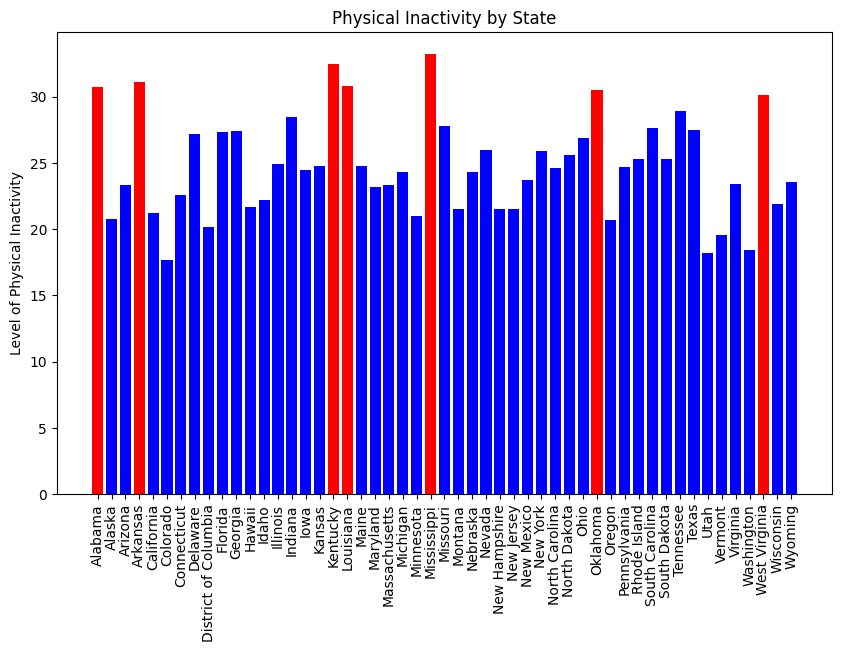

In [ ]:
# plt.dot(subrankings_data.index, subrankings_data['Physical Environment'])
categories = subrankings_data['State'].unique()
# Create a bar chart
physical_inactivity_level = [30.7, 20.8, 23.3, 31.1, 21.2,
                             17.7, 22.6, 27.2, 20.2, 27.3,
                             27.4, 21.7, 22.2, 24.9, 28.5,
                             24.5, 24.8, 32.5, 30.8, 24.8,
                             23.2, 23.3, 24.3, 21, 33.2,
                             27.8, 21.5, 24.3, 26, 21.5,
                             21.5, 23.7, 25.9, 24.6, 25.6,
                             26.9, 30.5, 20.7, 24.7, 25.3,
                             27.6, 25.3, 28.9, 27.5, 18.2,
                             19.6, 23.4, 18.4, 30.1, 21.9,
                             23.6] #New Jersey Data unavailable, imputed with New Hampshire data as 21.5
col = []
plt.figure(figsize=(10, 6))
for i in range(0, len(physical_inactivity_level)):
    if physical_inactivity_level[i] > 30:
        col.append('red')
    else:
        col.append('blue')

for i in range(0, len(physical_inactivity_level)):
  plt.bar(categories, physical_inactivity_level,color = col)
#plt.bar(categories, physical_inactivity_level)
# Set the axis labels and title
plt.xticks(rotation='vertical')
#plt.xlabel('States')
plt.ylabel('Level of Physical Inactivity')
# Set the desired tick positions and labels
num_ticks = 50
plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])
#plt.ylabel('Physical Environment')
plt.title('Physical Inactivity by State')

Notice: Alabama, Arkansas, Kentucky, Lousiana, Mississippi, Oklahoma, and West Virginia exhibit the highest average physical inactivity levels

Text(0.5, 1.0, 'Physical Inactivity of Least Active States')

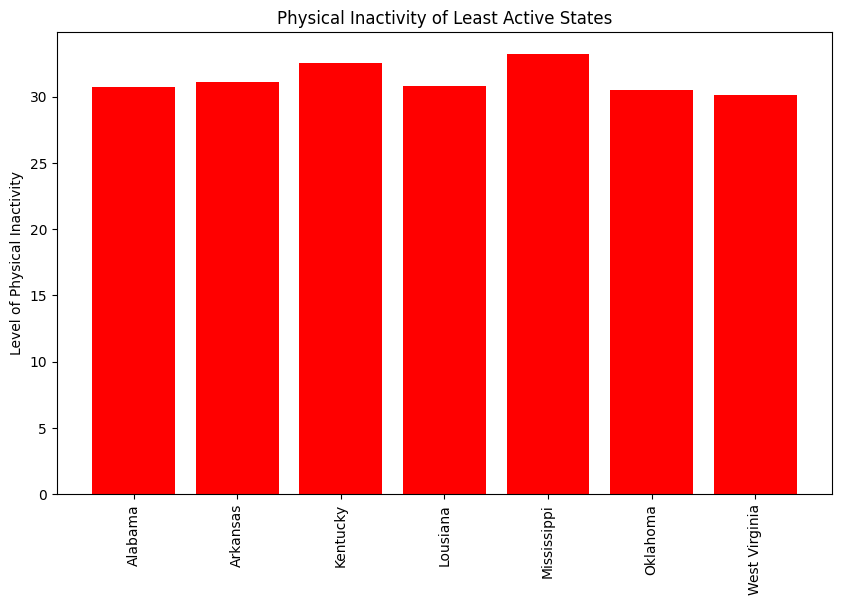

In [ ]:
# Create a bar chart
physical_inactivity_level_top_states = [30.7, 31.1, 32.5, 30.8, 33.2, 30.5, 30.1]
top_states = ['Alabama', 'Arkansas', 'Kentucky', 'Lousiana', 'Mississippi', 'Oklahoma', 'West Virginia']

plt.figure(figsize=(10, 6))
plt.bar(top_states, physical_inactivity_level_top_states, color = 'red')
# Set the axis labels and title
plt.xticks(rotation='vertical')
#plt.xlabel('States')
plt.ylabel('Level of Physical Inactivity')
# Set the desired tick positions and labels
#num_ticks = 7
#plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])
#plt.ylabel('Physical Environment')
plt.title('Physical Inactivity of Least Active States')

This bar chart compares the least active states with each other based on their levels of inactivity. Our knowledge of geography shows us that the least active states, in the south of the United States. To make further insights, we will use inductive reasoning and knowledge of socio-economic factors to look into this data.

# Map of Least Physically Active States

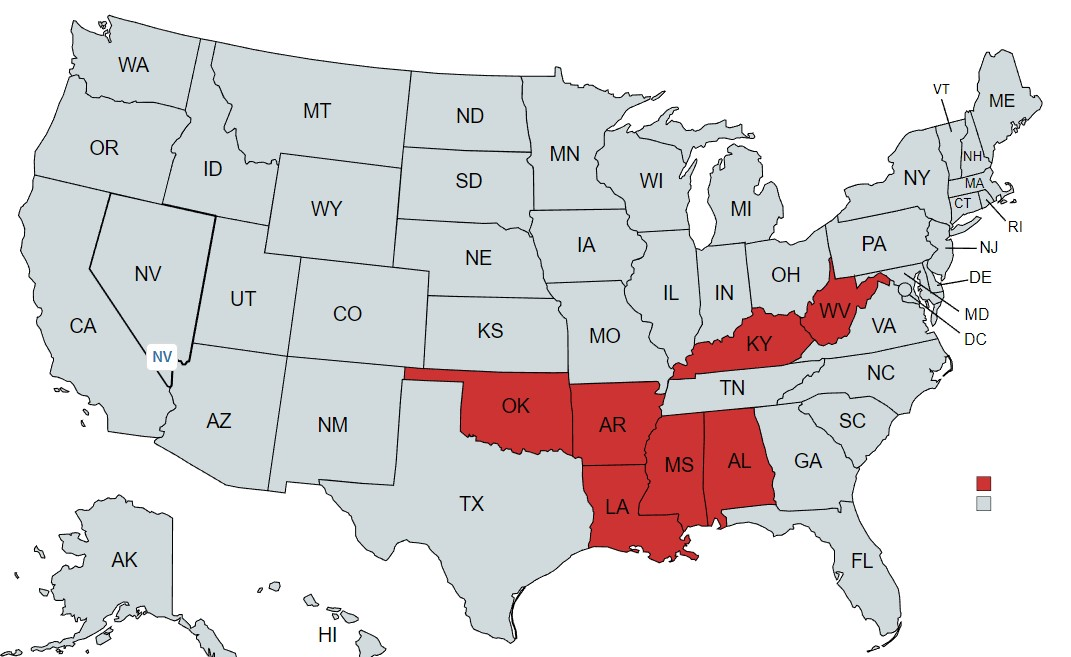

There are several hypothesis that can be made from this information and relevant outside knowledge. So what are some reasons these states are the least active?
1. Climate: Southern States are humid and exercise may be considerably more difficult than in a more temperate climate
2. Urban-Sprawl and Car-oriented lifestyle: A greater degree of automobile dependence can decrease the need for cycling, walking, and other physical activites.
3. Socio-economic factors: Low-Income communities may be more prevelant in these Southern states, which would warrant less leisure time to exercise.
4. Cultural Factors: An emphasis on sedentary activities across cultures may play a role
5. Health Disparities: Southern States have a larger population with chronic health conditions and diseases, which may discourage inactivity. (Which came first, the lack of exercise or the health conditions??)

Let's focus on Urban-Sprawl and Socio-Economic factors.
First, Socio-Economic Factors

#Total Unemployment in Each US State

In [ ]:
unemployment_data = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Unemployment in America Per US State.csv")

In [ ]:
#manually updated dataset, no longer need this
#unemployment_data = unemployment_data.drop(34)
#nemployment_data = unemployment_data.drop(5)

In [ ]:
unemployment_data.head(10)

,FIPS Code,State/Area,Year,Month,Total Civilian Non-Institutional Population in State/Area,Total Civilian Labor Force in State/Area,Percent (%) of State/Area's Population,Total Employment in State/Area,Percent (%) of Labor Force Employed in State/Area,Total Unemployment in State/Area,Percent (%) of Labor Force Unemployed in State/Area
0,1,Alabama,1976,1,"2,605,000","1,484,555",57.0,"1,386,023",53.2,"98,532",6.6
1,2,Alaska,1976,1,"232,000","160,183",69.0,"148,820",64.1,"11,363",7.1
2,4,Arizona,1976,1,"1,621,000","964,120",59.5,"865,871",53.4,"98,249",10.2
3,5,Arkansas,1976,1,"1,536,000","889,044",57.9,"824,395",53.7,"64,649",7.3
4,6,California,1976,1,"15,621,000","9,774,280",62.6,"8,875,685",56.8,"898,595",9.2
5,37,Los Angeles County,1976,1,"5,273,000","3,381,856",64.1,"3,081,806",58.4,"300,050",8.9
6,8,Colorado,1976,1,"1,832,000","1,230,966",67.2,"1,160,104",63.3,"70,862",5.8
7,9,Connecticut,1976,1,"2,248,000","1,442,847",64.2,"1,301,974",57.9,"140,873",9.8
8,10,Delaware,1976,1,"417,000","261,418",62.7,"240,543",57.7,"20,875",8.0
9,11,District of Columbia,1976,1,"520,000","334,691",64.4,"305,677",58.8,"29,014",8.7


In [ ]:
#Convert column of strings to floats and remove commas
unemployment_data['Total Unemployment in State/Area']=unemployment_data['Total Unemployment in State/Area'].str.replace(',','')
unemployment_data = unemployment_data.astype({'Total Unemployment in State/Area':'float'})

In [ ]:
print(categories)
print (len(categories))
lst = list(categories)
lst.append('No LA Data')
categories = np.asarray(lst)
print(len(categories))

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']
51
52


Text(0, 0.5, '# of People Unemployed')

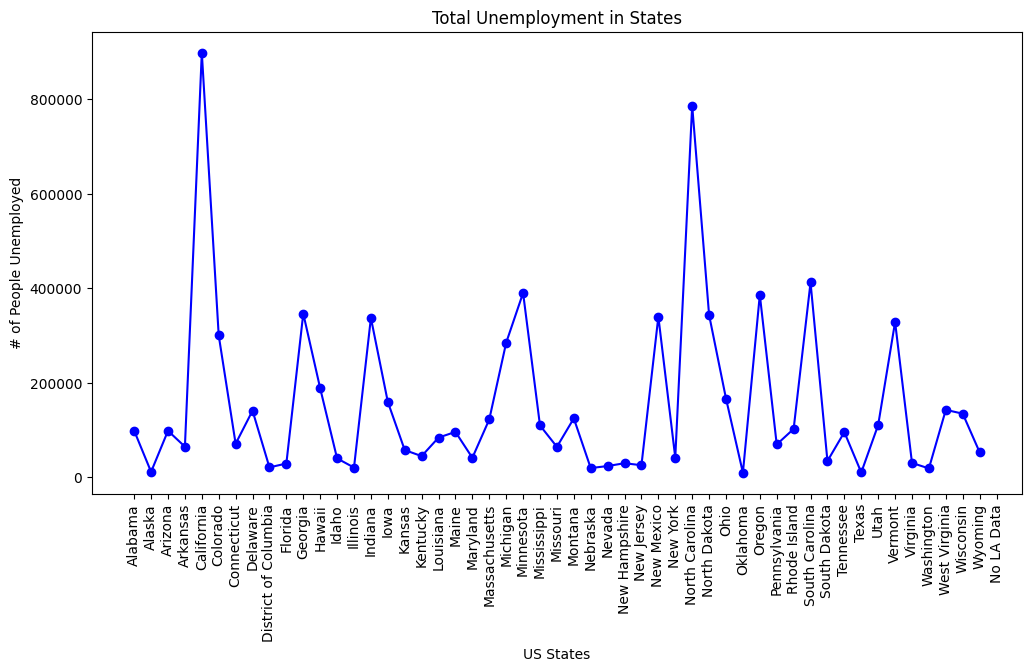

In [ ]:
#Extract x and y values from the data
FIPS_code = unemployment_data['State/Area'][:51]
percent_unemployed = unemployment_data['Total Unemployment in State/Area'][:51]
# Create the line graph
plt.figure(figsize=(12,6))

plt.plot(FIPS_code, percent_unemployed, marker = 'o', linestyle = '-', color = 'b')
plt.xticks(rotation = 'vertical')
num_ticks = 52
plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])
# Customize the graph
plt.title('Total Unemployment in States')
plt.xlabel('US States')
plt.ylabel('# of People Unemployed')


Woah! California and New York have the highest rates of unemployment! Does this mean that unemployment has nothing to do with levels of physical inactivity?

Not quite, this data shows the total number of unemployed people in the labor force, but does not take into account population size or density. Let's look at percentages to get a more accurate view of unemployment rates in states.

#Percentage of Unemployment in Each US State

In [ ]:
#Extract x and y values from the data
states = unemployment_data['State/Area'][:50]
percent_unemployed = unemployment_data['Percent (%) of Labor Force Unemployed in State/Area'][:50]

Text(0, 0.5, '% Unemployed')

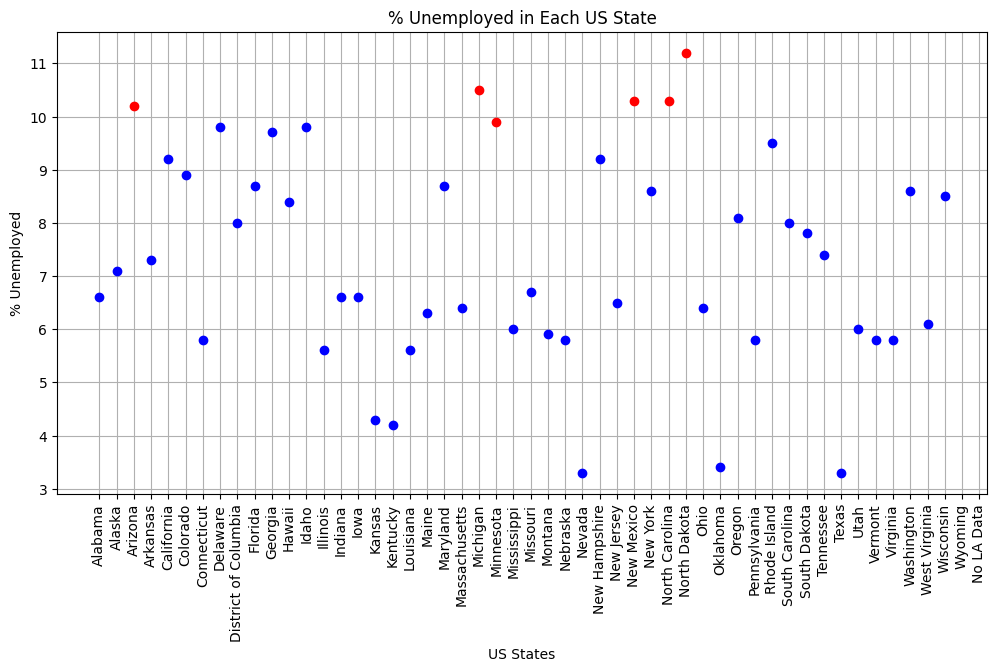

In [ ]:
#create different color points to showcase highest values
#to run this for loop, we need to replace of columns that we dropped to not be na, but just be gone
col =[]
plt.figure(figsize=(12,6))
plt.xticks(rotation = 'vertical')
num_ticks = 50
plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])
for i in range(0, len(states)):
    if percent_unemployed[i] > 9.8:
        col.append('red')
    else:
        col.append('blue')

for i in range(0, len(states)):
  plt.plot(states[i], percent_unemployed[i], color = col[i], marker = 'o', linestyle = '-')
# Customize the graph
plt.grid(True)
plt.title('% Unemployed in Each US State')
plt.xlabel('US States')
plt.ylabel('% Unemployed')

Observable from the graph above are the highest unemployment rates by state:
1. Arizona = 10.2
2. Massachusetts = 10.5
3. Michigan = 9.9
4. New Jersey = 10.3
5. New York = 10.3


Going back to our previous inductions, we theorized southern states would show a higher rate of unemployment, leading to less leisure time to devote to physical activity. However this data shows the highest rates of unemployment are in northern states. But this fact is not enough to disprove this idea.



# Unemployment Density Graph of United States

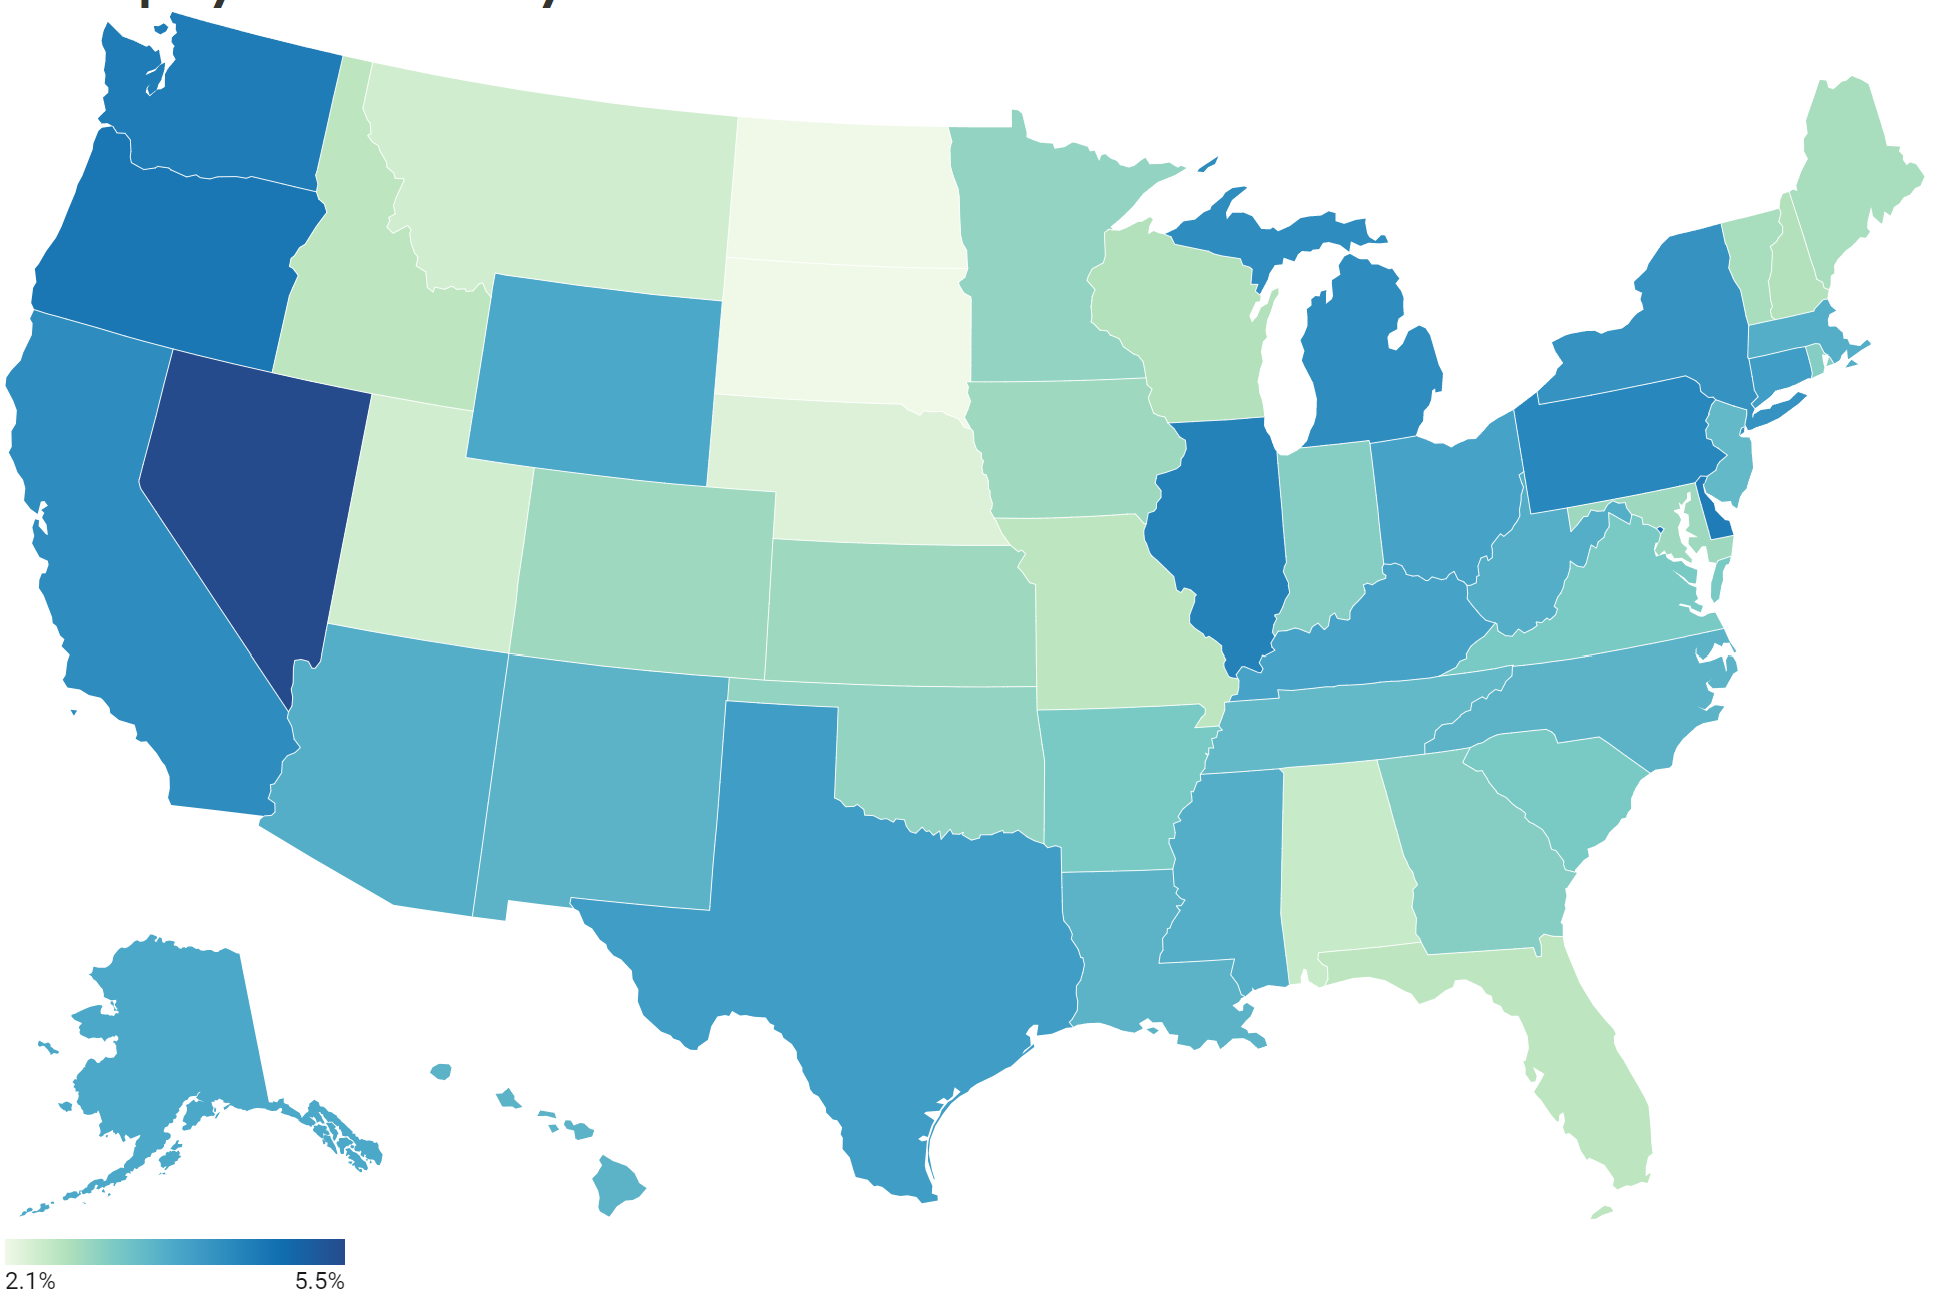

An important observation to be made from this graph, is that althought northern states hold the highest rates of unemployment, southern states still have a significantly higher unemployment rate than some midwest states. This data has potential for further analysis, but since our goal is PCA, we will move on to Urban Sprawl.

# Urban Sprawl Impacts on Physical Activity

In [ ]:
urban_sprawl = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/urban_sprawl.csv")

### Dataset Description
This dataset contains information describing the most urban areas in the United States in 2010. The descriptions include density factors, street indices, composite indices, and centering factors.

*   Density Factors - refer to various metrics or indicators used to assess population density and land use intensity within urban areas
*   Street Index - refers to a metric or indicator used to assess the connectivity and accessibility of street networks within urban areas
*   Centering Factors - refers to a measure or indicator used to quantify the degree of dispersion or concentration of urban development around a central point or core area.

*  Composite Index - refers to a summary measure that combines multiple indicators or metrics related to urban sprawl into a single index value

### Limitations of Dataset:
Curated in 2010. However, if an area was urban in 2010, it is likely urban in present time and the trends observed will be similar.

In [ ]:
urban_sprawl.head()

,UA10code,UA00code,UZA name,density factor10,mix factor10,centering factor10,street factor10,composite index10,density factor00,mix factor00,centering factor00,street factor00,composite index00,States
0,199,199,"Aberdeen--Bel Air South--Bel Air North, MD",85.49,120.77,76.74,77.96,96.00,85.05,130.29,74.74,47.27,85.29,MD
1,766,766,"Akron, OH",81.39,116.43,93.24,89.20,92.20,83.56,124.20,91.55,81.39,89.78,OH
2,970,928,"Albany--Schenectady, NY",97.77,118.87,112.62,89.20,106.98,97.62,126.41,111.23,76.74,102.59,NY
3,1171,1171,"Albuquerque, NM",116.44,78.03,93.50,122.76,101.29,115.40,83.47,88.92,111.01,96.53,NM
4,1495,1495,"Allentown, PA--NJ",97.96,143.39,104.15,137.07,131.35,98.60,154.60,98.74,137.75,133.48,PA


In [ ]:
unique_states = urban_sprawl['States'].unique()
itr = urban_sprawl['States'] #used to simulate switch statement
unique_states = sorted(unique_states)
print(unique_states) #unique states for switch statement

['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI']


In [ ]:
def normalize():
  return

In [ ]:
'''
This code gathers data in the density factor column and normalizes it. ie gets the mean of density values
Mathematical Concept   ------->    Sum of density values of cities in each state   /    # of cities in dataset
(The division is not done in this cell)
'''
md_d, oh_d, ny_d, nm_d, pa_d, mi_d, ca_d, wi_d, nc_d = 0, 0, 0, 0, 0, 0, 0, 0, 0
ga_d, la_d, tx_d, nj_d, al_d, id_d, fl_d, il_d, sc_d = 0, 0, 0, 0, 0, 0, 0, 0, 0
ia_d, co_d, or_d, in_d, ar_d, ms_d, ct_d, mo_d, wa_d = 0, 0, 0, 0, 0, 0, 0, 0, 0
tn_d, nv_d, ky_d, ne_d, mn_d, ut_d, ok_d, az_d, me_d = 0, 0, 0, 0, 0, 0, 0, 0, 0
va_d, dc_d = 0, 0

md_c, oh_c, ny_c, nm_c, pa_c, mi_c, ca_c, wi_c, nc_c = 0, 0, 0, 0, 0, 0, 0, 0, 0
ga_c, la_c, tx_c, nj_c, al_c, id_c, fl_c, il_c, sc_c = 0, 0, 0, 0, 0, 0, 0, 0, 0
ia_c, co_c, or_c, in_c, ar_c, ms_c, ct_c, mo_c, wa_c = 0, 0, 0, 0, 0, 0, 0, 0, 0
tn_c, nv_c, ky_c, ne_c, mn_c, ut_c, ok_c, az_c, me_c = 0, 0, 0, 0, 0, 0, 0, 0, 0
va_c, dc_c = 0, 0

for i in range (0, len(urban_sprawl['States'])):
    if itr[i] == 'MD':
      md_d += urban_sprawl['density factor10'][i]
      md_c += 1
    elif itr[i] == 'OH':
      oh_d += urban_sprawl['density factor10'][i]
      oh_c += 1
    elif itr[i] == 'NY':
      ny_d += urban_sprawl['density factor10'][i]
      ny_c += 1
    elif itr[i] == 'NM':
      nm_d += urban_sprawl['density factor10'][i]
      nm_c += 1
    elif itr[i] == 'PA':
      pa_d += urban_sprawl['density factor10'][i]
      pa_c += 1
    elif itr[i] == 'MI':
      mi_d += urban_sprawl['density factor10'][i]
      mi_c += 1
    elif itr[i] == 'CA':
      ca_d += urban_sprawl['density factor10'][i]
      ca_c += 1
    elif itr[i] == 'WI':
      wi_d += urban_sprawl['density factor10'][i]
      wi_c += 1
    elif itr[i] == 'NC':
      nc_d += urban_sprawl['density factor10'][i]
      nc_c += 1
    elif itr[i] == 'GA':
      ga_d += urban_sprawl['density factor10'][i]
      ga_c += 1
    elif itr[i] == 'LA':
      la_d += urban_sprawl['density factor10'][i]
      la_c += 1
    elif itr[i] == 'TX':
      tx_d += urban_sprawl['density factor10'][i]
      tx_c += 1
    elif itr[i] == 'NJ':
      nj_d += urban_sprawl['density factor10'][i]
      nj_c += 1
    elif itr[i] == 'AL':
      al_d += urban_sprawl['density factor10'][i]
      al_c += 1
    elif itr[i] == 'ID':
      id_d += urban_sprawl['density factor10'][i]
      id_c += 1
    elif itr[i] == 'FL':
      fl_d += urban_sprawl['density factor10'][i]
      fl_c += 1
    elif itr[i] == 'IL':
      il_d += urban_sprawl['density factor10'][i]
      il_c += 1
    elif itr[i] == 'SC':
      sc_d += urban_sprawl['density factor10'][i]
      sc_c += 1
    elif itr[i] == 'IA':
      ia_d += urban_sprawl['density factor10'][i]
      ia_c += 1
    elif itr[i] == 'CO':
      co_d += urban_sprawl['density factor10'][i]
      co_c += 1
    elif itr[i] == 'OR':
      or_d += urban_sprawl['density factor10'][i]
      or_c += 1
    elif itr[i] == 'IN':
      in_d += urban_sprawl['density factor10'][i]
      in_c += 1
    elif itr[i] == 'AR':
      ar_d += urban_sprawl['density factor10'][i]
      ar_c += 1
    elif itr[i] == 'MS':
      ms_d += urban_sprawl['density factor10'][i]
      ms_c += 1
    elif itr[i] == 'CT':
      ct_d += urban_sprawl['density factor10'][i]
      ct_c += 1
    elif itr[i] == 'MO':
      mo_d += urban_sprawl['density factor10'][i]
      mo_c += 1
    elif itr[i] == 'WA':
      wa_d += urban_sprawl['density factor10'][i]
      wa_c += 1
    elif itr[i] == 'TN':
      tn_d += urban_sprawl['density factor10'][i]
      tn_c += 1
    elif itr[i] == 'NV':
      nv_d += urban_sprawl['density factor10'][i]
      nv_c += 1
    elif itr[i] == 'KY':
      ky_d += urban_sprawl['density factor10'][i]
      ky_c += 1
    elif itr[i] == 'NE':
      ne_d += urban_sprawl['density factor10'][i]
      ne_c += 1
    elif itr[i] == 'MN':
      mn_d += urban_sprawl['density factor10'][i]
      mn_c += 1
    elif itr[i] == 'UT':
      ut_d += urban_sprawl['density factor10'][i]
      ut_c += 1
    elif itr[i] == 'OK':
      ok_d += urban_sprawl['density factor10'][i]
      ok_c += 1
    elif itr[i] == 'AZ':
      az_d += urban_sprawl['density factor10'][i]
      az_c += 1
    elif itr[i] == 'ME':
      me_d += urban_sprawl['density factor10'][i]
      me_c += 1
    elif itr[i] == 'VA':
      va_d += urban_sprawl['density factor10'][i]
      va_c += 1
    else:
      dc_d += urban_sprawl['density factor10'][i]
      dc_c += 1

In [ ]:
#division in mean calc is done here
md_d = md_d / md_c
oh_d = oh_d / oh_c
ny_d = ny_d / ny_c
nm_d = nm_d / nm_c
pa_d = pa_d / pa_c
mi_d = mi_d / mi_c
ca_d = ca_d / ca_c
wi_d = wi_d / wi_c
nc_d = nc_d / nc_c
ga_d = ga_d / ga_c
nj_d = nj_d / nj_c
tx_d = tx_d / tx_c
la_d = la_d / la_c
al_d = al_d / al_c
id_d = id_d / id_c
fl_d = fl_d / fl_c
il_d = il_d / il_c
sc_d = sc_d / sc_c
ia_d = ia_d / ia_c
co_d = co_d / co_c
or_d = or_d / or_c
in_d = in_d / in_c
ar_d = ar_d / ar_c
ms_d = ms_d / ms_c
ct_d = ct_d / ct_c
mo_d = mo_d / mo_c
wa_d = wa_d / wa_c
tn_d = tn_d / tn_c
nv_d = nv_d / nv_c
ky_d = ky_d / ky_c
ne_d = ne_d / ne_c
mn_d = mn_d / mn_c
ut_d = ut_d / ut_c
ok_d = ok_d / ok_c
az_d = az_d / az_c
me_d = me_d / me_c
va_d = va_d / va_c
dc_d = dc_d / va_c

Create Density list for graphing purposes

In [ ]:
density_list = [al_d, az_d, ar_d, ca_d, co_d, ct_d,
                dc_d, fl_d, ga_d, ia_d, id_d, il_d,
                in_d, ky_d, la_d, md_d, me_d, mi_d,
                mn_d, mo_d, ms_d, nc_d, ne_d, nj_d,
                nm_d, nv_d, ny_d, oh_d, ok_d, or_d,
                pa_d, sc_d, tn_d, tx_d, ut_d, va_d,
                wa_d, wi_d]

In [ ]:
print(density_list)

[77.3625, 109.6, 84.185, 129.675, 114.755, 85.36333333333334, 71.14, 90.02533333333334, 78.44800000000001, 95.06, 108.78, 98.352, 88.2675, 107.22333333333334, 92.29249999999999, 107.405, 88.48, 94.0, 112.17, 92.71, 72.305, 76.4890909090909, 114.555, 108.78999999999999, 116.44, 147.64, 113.83833333333332, 89.02222222222223, 93.365, 119.35666666666668, 101.87624999999998, 67.39333333333333, 83.91000000000001, 107.11384615384615, 114.29333333333334, 88.98, 102.08333333333333, 104.81]


Text(0, 0.5, 'Density Rating')

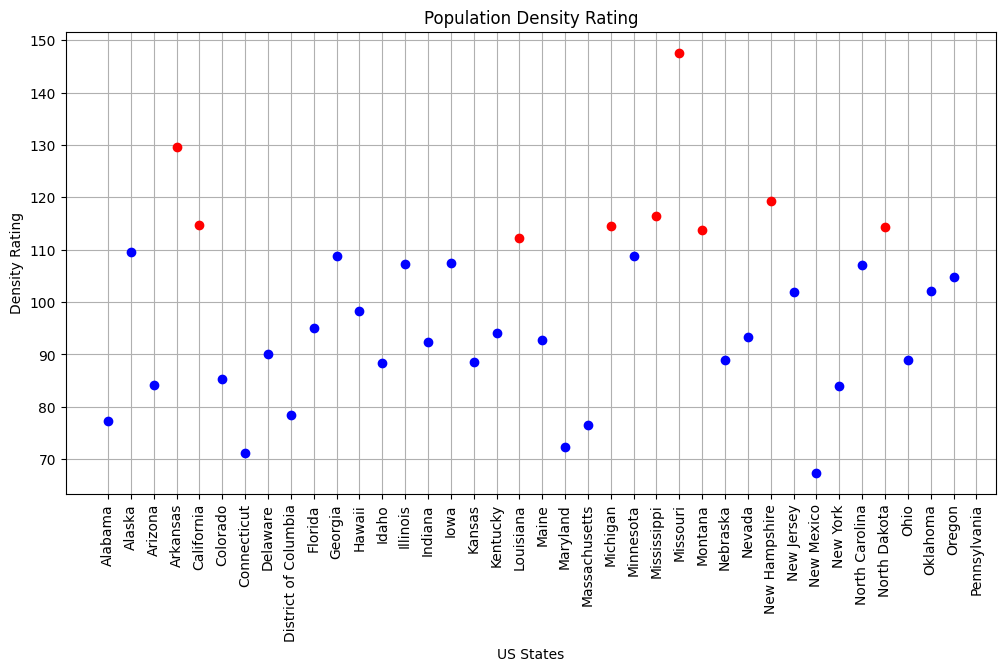

In [ ]:
#create different color points to showcase highest values
#to run this for loop, we need to replace of columns that we dropped to not be na, but just be gone
plt.figure(figsize=(12,6))
plt.xticks(rotation = 'vertical')
num_ticks = 50
plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])

col =[]
for i in range(0, len(unique_states)):
    if density_list[i] > 110:
        col.append('red')
    else:
        col.append('blue')

for i in range(0, len(unique_states)):
  plt.plot(unique_states[i], density_list[i], color = col[i], marker = 'o', linestyle = '-')

# Create the line graph
#plt.plot(unique_states, density_list, marker = 'o', linestyle = '-', color = 'b')
plt.grid(True)
# Customize the graph
plt.title('Population Density Rating')
plt.xlabel('US States')
plt.ylabel('Density Rating')

The graph here displays an image similar to what we observed from our physical inactivity data. The southern states are making the LEAST use of their land area

Note: Most urban sprawl datasets and discussions have a positive association with higher density ratings, the dataset I chose does the inverse. Moreover, we are only discussing the URBAN areas of these states, so while the southern states have less population density and more area per inhabitant, they are not utilizing URBAN space as well as other states.

## Total Composite Score Comparison

In [ ]:
'''
Compute and compare normalized values of composite scores
'''
md_overall, oh_overall, ny_overall, nm_overall, pa_overall, mi_overall, ca_overall, wi_overall, nc_overall = 0, 0, 0, 0, 0, 0, 0, 0, 0
ga_overall, la_overall, tx_overall, nj_overall, al_overall, id_overall, fl_overall, il_overall, sc_overall = 0, 0, 0, 0, 0, 0, 0, 0, 0
ia_overall, co_overall, or_overall, in_overall, ar_overall, ms_overall, ct_overall, mo_overall, wa_overall = 0, 0, 0, 0, 0, 0, 0, 0, 0
tn_overall, nv_overall, ky_overall, ne_overall, mn_overall, ut_overall, ok_overall, az_overall, me_overall = 0, 0, 0, 0, 0, 0, 0, 0, 0
va_overall, dc_overall = 0, 0

md_count, oh_count, ny_count, nm_count, pa_count, mi_count, ca_count, wi_count, nc_count = 0, 0, 0, 0, 0, 0, 0, 0, 0
ga_count, la_count, tx_count, nj_count, al_count, id_count, fl_count, il_count, sc_count = 0, 0, 0, 0, 0, 0, 0, 0, 0
ia_count, co_count, or_count, in_count, ar_count, ms_count, ct_count, mo_count, wa_count = 0, 0, 0, 0, 0, 0, 0, 0, 0
tn_count, nv_count, ky_count, ne_count, mn_count, ut_count, ok_count, az_count, me_count = 0, 0, 0, 0, 0, 0, 0, 0, 0
va_count, dc_count = 0, 0

for i in range (0, len(urban_sprawl['States'])):
    if itr[i] == 'MD':
      md_overall += urban_sprawl['composite index10'][i]
      md_count += 1
    elif itr[i] == 'OH':
      oh_overall += urban_sprawl['composite index10'][i]
      oh_count += 1
    elif itr[i] == 'NY':
      ny_overall += urban_sprawl['composite index10'][i]
      ny_count += 1
    elif itr[i] == 'NM':
      nm_overall += urban_sprawl['composite index10'][i]
      nm_count += 1
    elif itr[i] == 'PA':
      pa_overall += urban_sprawl['composite index10'][i]
      pa_count += 1
    elif itr[i] == 'MI':
      mi_overall += urban_sprawl['composite index10'][i]
      mi_count += 1
    elif itr[i] == 'CA':
      ca_overall += urban_sprawl['composite index10'][i]
      ca_count += 1
    elif itr[i] == 'WI':
      wi_overall += urban_sprawl['composite index10'][i]
      wi_count += 1
    elif itr[i] == 'NC':
      nc_overall += urban_sprawl['composite index10'][i]
      nc_count += 1
    elif itr[i] == 'GA':
      ga_overall += urban_sprawl['composite index10'][i]
      ga_count += 1
    elif itr[i] == 'LA':
      la_overall += urban_sprawl['composite index10'][i]
      la_count += 1
    elif itr[i] == 'TX':
      tx_overall += urban_sprawl['composite index10'][i]
      tx_count += 1
    elif itr[i] == 'NJ':
      nj_overall += urban_sprawl['composite index10'][i]
      nj_count += 1
    elif itr[i] == 'AL':
      al_overall += urban_sprawl['composite index10'][i]
      al_count += 1
    elif itr[i] == 'ID':
      id_overall += urban_sprawl['composite index10'][i]
      id_count += 1
    elif itr[i] == 'FL':
      fl_overall += urban_sprawl['composite index10'][i]
      fl_count += 1
    elif itr[i] == 'IL':
      il_overall += urban_sprawl['composite index10'][i]
      il_count += 1
    elif itr[i] == 'SC':
      sc_overall += urban_sprawl['composite index10'][i]
      sc_count += 1
    elif itr[i] == 'IA':
      ia_overall += urban_sprawl['composite index10'][i]
      ia_count += 1
    elif itr[i] == 'CO':
      co_overall += urban_sprawl['composite index10'][i]
      co_count += 1
    elif itr[i] == 'OR':
      or_overall += urban_sprawl['composite index10'][i]
      or_count += 1
    elif itr[i] == 'IN':
      in_overall += urban_sprawl['composite index10'][i]
      in_count += 1
    elif itr[i] == 'AR':
      ar_overall += urban_sprawl['composite index10'][i]
      ar_count += 1
    elif itr[i] == 'MS':
      ms_overall += urban_sprawl['composite index10'][i]
      ms_count += 1
    elif itr[i] == 'CT':
      ct_overall += urban_sprawl['composite index10'][i]
      ct_count += 1
    elif itr[i] == 'MO':
      mo_overall += urban_sprawl['composite index10'][i]
      mo_count += 1
    elif itr[i] == 'WA':
      wa_overall += urban_sprawl['composite index10'][i]
      wa_count += 1
    elif itr[i] == 'TN':
      tn_overall += urban_sprawl['composite index10'][i]
      tn_count += 1
    elif itr[i] == 'NV':
      nv_overall += urban_sprawl['composite index10'][i]
      nv_count += 1
    elif itr[i] == 'KY':
      ky_overall += urban_sprawl['composite index10'][i]
      ky_count += 1
    elif itr[i] == 'NE':
      ne_overall += urban_sprawl['composite index10'][i]
      ne_count += 1
    elif itr[i] == 'MN':
      mn_overall += urban_sprawl['composite index10'][i]
      mn_count += 1
    elif itr[i] == 'UT':
      ut_overall += urban_sprawl['composite index10'][i]
      ut_count += 1
    elif itr[i] == 'OK':
      ok_overall += urban_sprawl['composite index10'][i]
      ok_count += 1
    elif itr[i] == 'AZ':
      az_overall += urban_sprawl['composite index10'][i]
      az_count += 1
    elif itr[i] == 'ME':
      me_overall += urban_sprawl['composite index10'][i]
      me_count += 1
    elif itr[i] == 'VA':
      va_overall += urban_sprawl['composite index10'][i]
      va_count += 1
    else:
      dc_overall += urban_sprawl['composite index10'][i]
      dc_count += 1

In [ ]:
md_overall = md_overall / md_count
oh_overall = oh_overall / oh_count
ny_overall = ny_overall / ny_count
nm_overall = nm_overall / nm_count
pa_overall = pa_overall / pa_count
mi_overall = mi_overall / mi_count
ca_overall = ca_overall / ca_count
wi_overall = wi_overall / wi_count
nc_overall = nc_overall / nc_count
ga_overall = ga_overall / ga_count
nj_overall = nj_overall / nj_count
tx_overall = tx_overall / tx_count
la_overall = la_overall / la_count
al_overall = al_overall / al_count
id_overall = id_overall / id_count
fl_overall = fl_overall / fl_count
il_overall = il_overall / il_count
sc_overall = sc_overall / sc_count
ia_overall = ia_overall / ia_count
co_overall = co_overall / co_count
or_overall = or_overall / or_count
in_overall = in_overall / in_count
ar_overall = ar_overall / ar_count
ms_overall = ms_overall / ms_count
ct_overall = ct_overall / ct_count
mo_overall = mo_overall / mo_count
wa_overall = wa_overall / wa_count
tn_overall = tn_overall / tn_count
nv_overall = nv_overall / nv_count
ky_overall = ky_overall / ky_count
ne_overall = ne_overall / ne_count
mn_overall = mn_overall / mn_count
ut_overall = ut_overall / ut_count
ok_overall = ok_overall / ok_count
az_overall = az_overall / az_count
me_overall = me_overall / me_count
va_overall = va_overall / va_count
dc_overall = dc_overall / va_count

In [ ]:
composite_list = [al_overall, az_overall, ar_overall, ca_overall, co_overall, ct_overall,
                dc_overall, fl_overall, ga_overall, ia_overall, id_overall, il_overall,
                in_overall, ky_overall, la_overall, md_overall, me_overall, mi_overall,
                mn_overall, mo_overall, ms_overall, nc_overall, ne_overall, nj_overall,
                nm_overall, nv_overall, ny_overall, oh_overall, ok_overall, or_overall,
                pa_overall, sc_overall, tn_overall, tx_overall, ut_overall, va_overall,
                wa_overall, wi_overall]

In [ ]:
print(composite_list)

[88.155, 78.905, 90.5, 117.2895, 113.005, 92.61333333333333, 53.845, 82.90266666666668, 75.622, 112.59, 113.63, 106.008, 97.375, 105.20333333333333, 93.61, 109.245, 130.27, 93.988, 97.57, 94.85, 81.18, 72.81, 129.765, 138.16500000000002, 101.29, 102.24, 105.74833333333333, 99.00333333333333, 89.98500000000001, 137.39666666666668, 126.70625, 70.54666666666667, 70.14333333333333, 98.10846153846154, 101.25333333333333, 99.41, 110.83333333333333, 127.17]


Text(0, 0.5, 'Composite Rating')

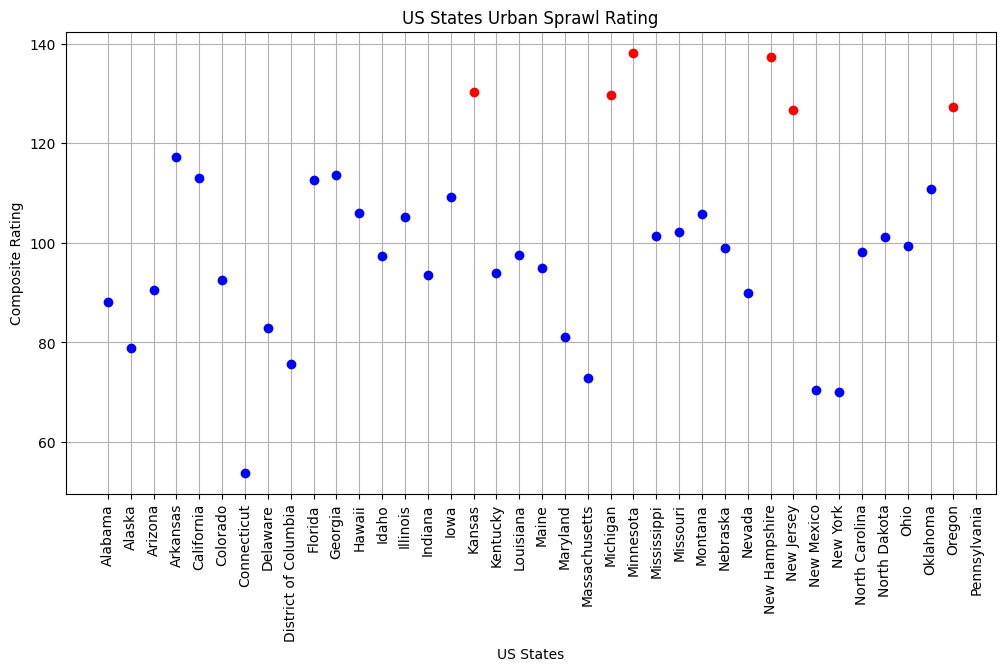

In [ ]:
#create different color points to showcase highest values
#to run this for loop, we need to replace of columns that we dropped to not be na, but just be gone
plt.figure(figsize=(12,6))
plt.xticks(rotation = 'vertical')
num_ticks = 50
plt.xticks(range(len(categories))[::len(categories)//num_ticks], categories[::len(categories)//num_ticks])

col =[]
for i in range(0, len(unique_states)):
    if composite_list[i] > 120:
        col.append('red')
    else:
        col.append('blue')

for i in range(0, len(unique_states)):
  plt.plot(unique_states[i], composite_list[i], color = col[i], marker = 'o', linestyle = '-')

# Create the line graph
#plt.plot(unique_states, density_list, marker = 'o', linestyle = '-', color = 'b')
plt.grid(True)
# Customize the graph
plt.title('US States Urban Sprawl Rating')
plt.xlabel('US States')
plt.ylabel('Composite Rating')

This new graph gives us a lot of helpful information. While some states that exhibit high composite urban sprawl ratings (they use space ineffectively) are in the north, this data aligns well with our real physical inactivity dataset. At this point, we can begin our Principal Component Analysis.

#Principal Component Analysis

In [ ]:
combined_dataset = pd.read_csv("drive/My Drive/DataSets/Healthy Communities/Combined_Dataset.csv")

In [ ]:
combined_dataset = combined_dataset.drop('State', axis=1)
#Convert column of strings to floats and remove commas
combined_dataset['Total Unemployment in State/Area']=combined_dataset['Total Unemployment in State/Area'].str.replace(',','')
combined_dataset = combined_dataset.astype({'Total Unemployment in State/Area':'float'})

Let's Normalize the only component we need to, Total Unemployment

In [ ]:
min_val = min(combined_dataset['Total Unemployment in State/Area'])  # Find the minimum value in the column
max_val = max(combined_dataset['Total Unemployment in State/Area'])  # Find the maximum value in the column

normalized_data = [(value - min_val) / (max_val - min_val) for value in combined_dataset['Total Unemployment in State/Area']]

print(normalized_data)

[0.10245962788662714, 0.004670207932510279, 0.10214214798153456, 0.06444842073379366, 1.0, 0.07141839476326432, 0.14995933340438303, 0.015341122622406453, 0.3805451006568356, 0.20316806802820297, 0.036651540562825685, 0.014835174081075169, 0.37019951873187534, 0.17085242793598798, 0.05644747839061247, 0.04202738404411063, 0.08607295306794406, 0.09951592728251785, 0.038042618592206597, 0.12910325949775353, 0.3113311158352919, 0.4295424587304169, 0.11483685683675587, 0.06409167652948468, 0.13164982976121697, 0.013672950824269824, 0.01847104818851351, 0.025180756006035483, 0.020445481520538034, 0.37319145833216477, 0.038575491224429125, 0.8745965593255515, 0.17882868986251885, 0.002608271305089214, 0.4250371608546155, 0.06974910112800722, 0.10656891725890318, 0.45436983604350484, 0.030371496362443136, 0.09897968913893392, 0.0032073323274193818, 0.11597327783979045, 0.360567425215533, 0.025871807672244066, 0.012796796033183943, 0.1519281575508052, 0.14284015503789005, 0.05134087581823995, 

###This code is going to normalize a big chunk of data

In [ ]:
#Let's Normalize two other categories
min_val = min(combined_dataset['centering factor10'])  # Find the minimum value in the column
max_val = max(combined_dataset['centering factor10'])  # Find the maximum value in the column

normalized_data1 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['centering factor10']]

print(normalized_data1)

min_val = min(combined_dataset['street factor10'])  # Find the minimum value in the column
max_val = max(combined_dataset['street factor10'])  # Find the maximum value in the column

normalized_data2 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['street factor10']]

print(normalized_data2)

min_val = min(combined_dataset['Food Environment Index'])  # Find the minimum value in the column
max_val = max(combined_dataset['Food Environment Index'])  # Find the maximum value in the column

normalized_data3 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['Food Environment Index']]

print(normalized_data3)

min_val = min(combined_dataset['% With Access to Exercise Opportunities'])  # Find the minimum value in the column
max_val = max(combined_dataset['% With Access to Exercise Opportunities'])  # Find the maximum value in the column

normalized_data4 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['% With Access to Exercise Opportunities']]

print(normalized_data4)

min_val = min(combined_dataset['% Excessive Drinking'])  # Find the minimum value in the column
max_val = max(combined_dataset['% Excessive Drinking'])  # Find the maximum value in the column

normalized_data5 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['% Excessive Drinking']]

print(normalized_data5)

min_val = min(combined_dataset['# Completed High School'])  # Find the minimum value in the column
max_val = max(combined_dataset['# Completed High School'])  # Find the maximum value in the column

normalized_data6 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['# Completed High School']]

print(normalized_data6)

min_val = min(combined_dataset['% Children in Poverty'])  # Find the minimum value in the column
max_val = max(combined_dataset['% Children in Poverty'])  # Find the maximum value in the column

normalized_data7 = [(value - min_val) / (max_val - min_val) for value in combined_dataset['% Children in Poverty']]

print(normalized_data7)

[0.2093710010827837, 0.37178856186632536, 0.5625553696229945, 0.37434786888473276, 0.4791810217541097, 0.9041244216950486, 0.0, 0.7253666699478295, 0.47504675657052864, 0.5100895757456443, 1.0, 0.3827148341372182, 0.7742888079535387, 0.20641795452308295, 0.6657151294418742, 0.21399744069298154, 0.49719460576828434, 0.2019883846835318, 0.06427798011615317, 0.048528398464415784, 0.3751353479673196, 0.23742494339994097, 0.46018308888670145, 0.60990254946353, 0.5952357515503495, 0.40909538340387835, 0.895166847130623, 0.5220986317550941, 0.38921153656855995, 0.6154149030416379, 0.5321389900580766, 0.5024116546904224, 0.3257210355349936, 0.08130721527709418, 0.34875479870065956, 0.3053450142730583, 0.4575253469829708, 0.1731469632837878, 0.33211930308101184, 0.10709715523181411, 0.6232896938675067, 0.36735899202677436, 0.3561374150999115, 0.4023033763165666, 0.22325031991337735, 0.7744856777241855, 0.37995865734816414, 0.11507038094300617, 0.39846441578895564, 0.4104734717984054]
[0.3842272

In [ ]:
# Split the dataset into features (X) and target variable (y)
X = combined_dataset.drop('Physical Inactivity', axis=1)
y = combined_dataset[['Physical Inactivity', 'Total Unemployment in State/Area', 'Sprawl Composite Score', 'Population Density Score']]
y_1 = combined_dataset['Physical Inactivity']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle = True, random_state = 42)

# Create a multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'Multiple Linear Regression Results')

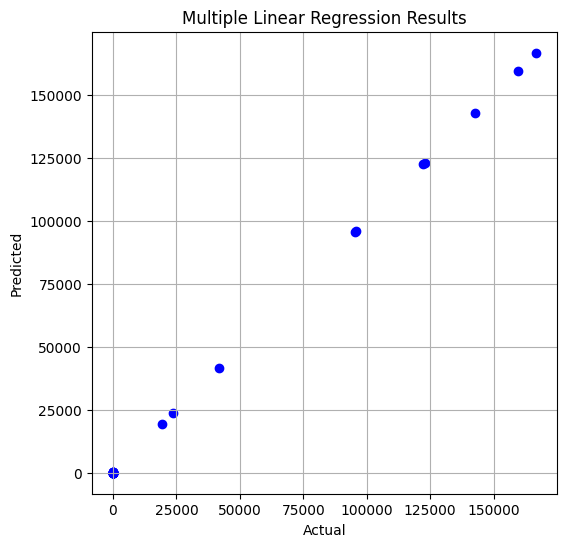

In [ ]:
#PLOT DA RESULTS
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.scatter(y_test,y_pred, color = 'blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multiple Linear Regression Results')

In [ ]:
mean_absolute_error(y_pred, y_test)

0.5302797637028076

In [ ]:
model.score(X_train, y_train)

0.7915567448936953

In [ ]:
print(f"pred:\n{y_pred}")

pred:
[[2.46597595e+01 1.59497000e+05 9.73750000e+01 8.82675000e+01]
 [2.64797067e+01 9.54300000e+04 7.05460000e+01 6.73930000e+01]
 [2.45048022e+01 4.15860000e+04 1.01290000e+02 1.16440000e+02]
 [2.56310208e+01 1.42628000e+05 9.94100000e+01 8.89800000e+01]
 [2.57203307e+01 9.59080000e+04 9.36100000e+01 9.22924000e+01]
 [2.46698897e+01 1.22896000e+05 1.27170000e+02 1.04810000e+02]
 [2.41979136e+01 2.36650000e+04 1.29765000e+02 1.14555000e+02]
 [2.42941480e+01 1.93880000e+04 7.85000000e+01 7.82000000e+01]
 [2.33200971e+01 1.66607000e+05 7.28100000e+01 7.64890000e+01]
 [2.43891374e+01 1.22282000e+05 1.09245000e+02 1.07405000e+02]]


In [ ]:
model.score(X_test, y_test)

0.800384635763371

In [ ]:
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)

Coefficients:  [[ 9.55813615e-07 -2.08459264e-01  4.18379736e-03 -3.75298859e-02
  -1.84589815e-02  2.00647251e-02  5.93591502e-01  4.39256058e-02
  -8.01213288e-01  1.88755649e-06  2.96789031e-02]
 [ 1.00000000e+00  7.65385709e-13 -3.07221629e-14  8.47665447e-14
  -2.01722467e-14  3.48178495e-14 -2.26026048e-12  2.40166364e-13
   1.14446656e-12 -3.30336065e-17  7.24452949e-14]
 [ 6.57419665e-20 -5.09531653e-15  1.14132210e-16  1.00000000e+00
  -3.83609746e-16  1.23447905e-17  2.45790085e-14  8.91051992e-16
  -1.49802746e-14  1.62630326e-19  3.52153759e-16]
 [ 1.26935766e-19 -2.50570506e-14  1.00000000e+00 -4.48373476e-16
   1.50188008e-16  4.31305021e-16 -1.17950420e-14  8.21188728e-16
  -1.18817381e-15 -3.79470760e-19  1.08767272e-16]]
Intercept:  [ 3.51019040e+01 -5.82076609e-11  1.13686838e-13  2.55795385e-13]


## Lets try to do some PCA to confirm what we thought. That these two components (unemployment rate and urban sprawl) are very important!

In [ ]:
# Grab all our pca data
pca_data = combined_dataset[['Total Unemployment in State/Area',
                             'Percent (%) of Labor Force Unemployed in State/Area',
                             'Population Density Score', 'Sprawl Composite Score',
                             'centering factor10', 'street factor10',
                             'Food Environment Index', '% With Access to Exercise Opportunities',
                             '% Excessive Drinking', '# Completed High School',
                             '% Children in Poverty']]

# Create a PCA instance
pca = PCA(n_components=2)  # Specify the number of components to keep

# Fit the data to the PCA model
pca.fit(pca_data)

# Transform the data to the new coordinate system
X_pca = pca.transform(pca_data)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
important_components = pca.components_

# Print the transformed data and explained variance ratio
#print("Original Data:\n", X)
#print("Transformed Data:\n", X_pca)
print("Explained Variance Ratio:", explained_variance_ratio)
print("Important Components: ", important_components)

Explained Variance Ratio: [0.84147548 0.15852451]
Important Components:  [[-1.39711632e-02 -2.66347916e-07 -5.38177941e-06 -1.60302699e-06
  -7.11640828e-06 -4.19630218e-06 -3.83791939e-07  1.01671934e-05
   3.85648031e-07  9.99902398e-01 -2.61949161e-06]
 [ 9.99902397e-01  4.89239669e-06  3.52532014e-05  3.49622598e-05
   4.39514947e-07  1.85351997e-05  3.23600639e-07 -1.75990698e-05
   5.62131290e-07  1.39711637e-02  4.51723781e-07]]


Text(0.5, 1.0, 'PCA Scatter Plot')

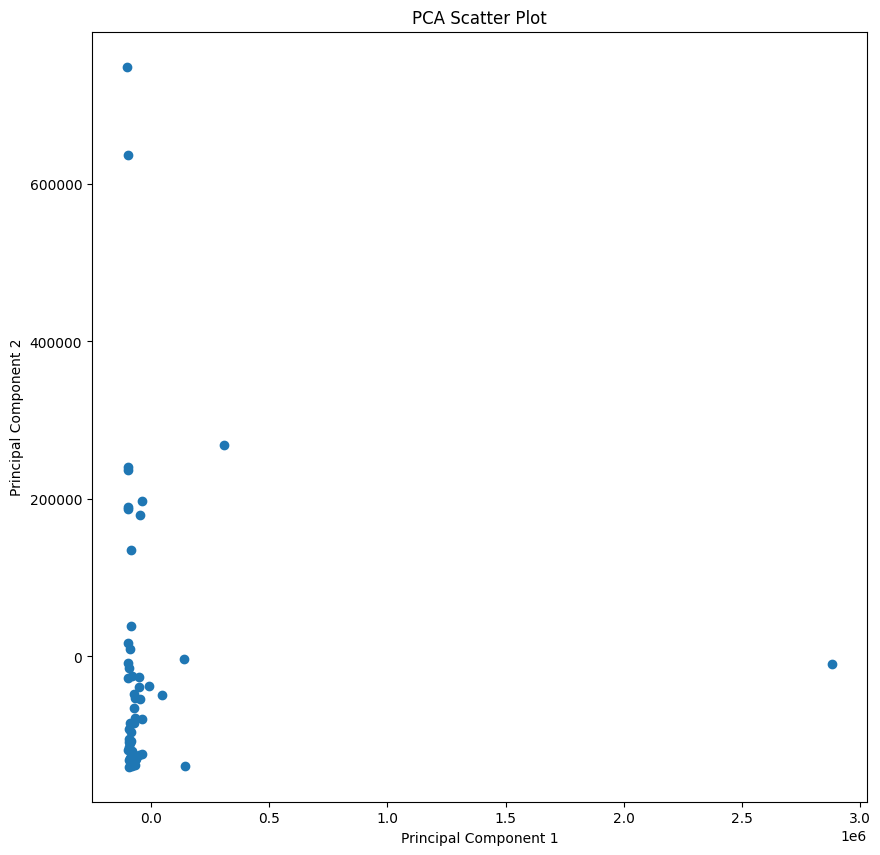

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

###Let's look at our reconstructed data after PCA

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca)

Let's plot the most important componet

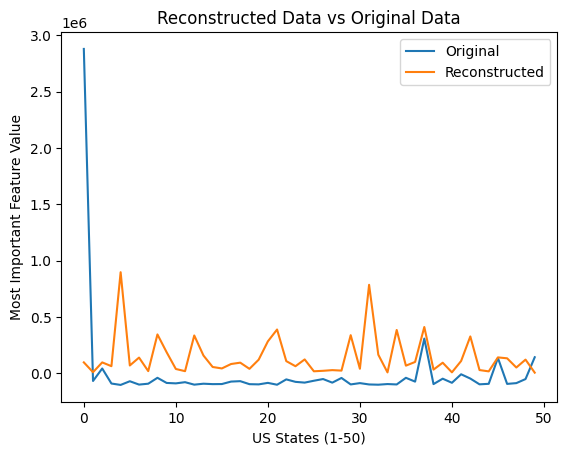

In [ ]:
# Choose a specific feature or column to visualize
feature_index = 0
#0 is here because we have 2 features in our PCA, and all goat languages index from 0
#Our first component (.ie element 0) explains about 85% of our data, so we will plot that one and ignore the 2nd component

# Plot the original data
plt.plot(X_pca[:, feature_index], label='Original')

# Plot the reconstructed data
plt.plot(X_reconstructed[:, feature_index], label='Reconstructed')

plt.xlabel('US States (1-50)') #name of US States is not important here, we just want to observe how well our PCA did
plt.ylabel('Most Important Feature Value')
plt.title('Reconstructed Data vs Original Data')
plt.legend()

### Thoughts and Lessons Learned



1.   The data collection step is vital. Even the best models can not make a lack of quantity or quality of data into useful information. In the future, I will outline my goals concretely, and before beginning any coding, make sure I have a feasible amount of data to see my idea to fruition
2.   Different types of problems require different types of solutions. I debated whether this project required a regressor or classifier solution, when that should have been clear from the beginning had I been as knowledgable as I need to be. I wll benefit from more background statistics knowledge and python model implementation.



3. EDIT: THIS HAS BEEN DONE! I would like to reconstruct the transformed data to really reveal if my eda observations were correct. In the future, I would like to practice inverting the transformed PCA data and computing the loss during the transformation to determine the efficacy of my PCA.
4. I would like to explore different techniques to determine what features were most important and confirm my eda findings from earlier

Outside Works Credited:

Forbes Advisor: [Click Here](https://www.forbes.com/advisor/personal-finance/unemployment-rates-by-state-04-11-23/#:~:text=States%20With%20the%20Highest%20Unemployment,summary%20MISSING%3A%20current%2Drows.)

National Cancer Institute: [Click Here](https://gis.cancer.gov/tools/urban-sprawl/)